In [41]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, brier_score_loss, roc_curve, roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

In [42]:
def calculate_metrics(FP, FN, TP, TN):
    P = TP + FN
    N = TN + FP

    TPR = TP/P if P != 0 else 0
    TNR = TN/N if N != 0 else 0
    FPR = FP/N if N != 0 else 0
    FNR = FN/P if P != 0 else 0

    recall = TPR
    precision = TP/(TP+FP) if (TP+FP) != 0 else 0
    F1 = (2*TP)/(2*TP+FP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    error_rate = (FP+FN)/(TP+TN+FP+FN)

    BACC = (TPR+TNR)/2
    TSS = (TP/(TP+FN))-(FP/(FP+TN))
    HSS = (2*((TP*TN)-(FP*FN)))/(((TP+FN)*(FN+TN)) + ((TP+FP)*(FP+TN)))

    return {
        'TPR': TPR,
        'TNR': TNR,
        'FPR': FPR,
        'FNR': FNR,
        'Recall': recall,
        'Precision': precision,
        'F1': F1,
        'Accuracy': accuracy,
        'Error Rate': error_rate,
        'BACC': BACC,
        'TSS': TSS,
        'HSS': HSS
    }

In [43]:
def k_fold(X, Y, K, model):
    kf = KFold(n_splits=K, shuffle = True, random_state=42)
    metrics_list = []
    cumulative_cm = np.zeros((2, 2), dtype=int)
    all_y_true = []
    all_y_prob = []

    for i, (train_index, test_index) in enumerate(kf.split(X), start = 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        if model == 'Random Forest':
            rf  = RandomForestClassifier()
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_test)
            y_prob = rf.predict_proba(X_test)[:, 1]
            brier_score = brier_score_loss(y_test,y_prob)
            roc_auc = roc_auc_score(y_test, y_prob)

            all_y_true.extend(y_test)
            all_y_prob.extend(y_prob)
        elif model == 'SVM':
            clf = svm.SVC(kernel='linear', probability=True) 
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)[:, 1]
            brier_score = brier_score_loss(y_test,y_prob)
            roc_auc = roc_auc_score(y_test, y_prob)          
            
            all_y_true.extend(y_test)
            all_y_prob.extend(y_prob)
        elif model == 'LSTM':
            # Scale and reshape data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
            X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

            # Define the LSTM model with Input layer
            lstm_model = Sequential([
                Input(shape=(X_train.shape[1], X_train.shape[2])),
                LSTM(50, activation='relu'),
                Dropout(0.2),
                Dense(1, activation='sigmoid')
            ])
            lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

            # Train the LSTM model
            lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

            # Predict and convert probabilities to binary labels
            y_pred_prob = lstm_model.predict(X_test)
            brier_score = brier_score_loss(y_test, y_pred_prob)
            roc_auc = roc_auc_score(y_test, y_pred_prob)          
            y_pred = (y_pred_prob > 0.5).astype(int).flatten()

            all_y_true.extend(y_test)
            all_y_prob.extend(y_pred_prob)

        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
        TP = cm[0, 0]
        FN = cm[0, 1]
        FP = cm[1, 0]
        TN = cm[1, 1]

        cumulative_cm += cm # Add current fold's confusion matrix to the cumulative matrix

        fold_metrics = calculate_metrics(FP,FN,TP,TN)
        fold_metrics['Fold'] = i
        fold_metrics['Brier Score'] = brier_score
        fold_metrics['AUC'] = roc_auc
        metrics_list.append(fold_metrics)
    
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.set_index('Fold', inplace=True)

    avg_metrics = metrics_df.mean().to_dict()
    avg_metrics['Fold'] = 'Average'
    metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_metrics]).set_index('Fold')])

    print(f"Metrics Table Across All Folds for {model}:\n")
    print(metrics_df)

    disp = ConfusionMatrixDisplay(confusion_matrix=cumulative_cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title('Cumulative Confusion Matrix After All Folds')
    plt.show()

    roc_auc = roc_auc_score(all_y_true, all_y_prob)
    fpr, tpr, threshold = roc_curve(all_y_true, all_y_prob)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guess
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return metrics_df

Metrics Table Across All Folds for Random Forest:

              TPR       TNR       FPR  ...       HSS  Brier Score       AUC
Fold                                   ...                                 
1        0.882353  0.714286  0.285714  ...  0.604255     0.141439  0.871849
2        0.937500  0.933333  0.066667  ...  0.870833     0.080432  0.972917
3        0.789474  0.666667  0.333333  ...  0.456140     0.151335  0.853070
4        0.833333  0.916667  0.083333  ...  0.729730     0.118303  0.893519
5        0.923077  0.823529  0.176471  ...  0.733333     0.140883  0.900452
6        0.944444  0.666667  0.333333  ...  0.637681     0.114820  0.930556
7        0.866667  0.533333  0.466667  ...  0.400000     0.181590  0.842222
8        0.888889  0.750000  0.250000  ...  0.647887     0.128513  0.909722
9        0.800000  0.933333  0.066667  ...  0.733333     0.109403  0.942222
10       0.875000  0.714286  0.285714  ...  0.594595     0.106347  0.930804
Average  0.874074  0.765210  0.234790

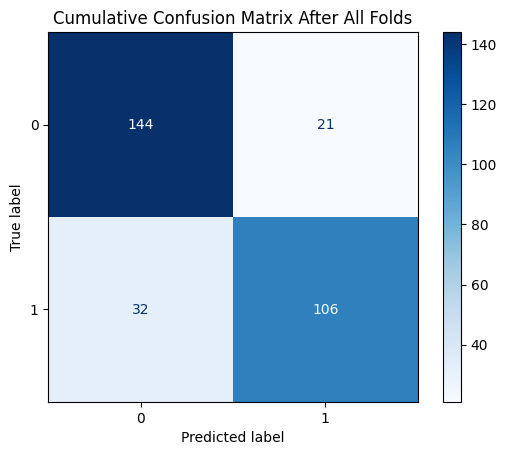

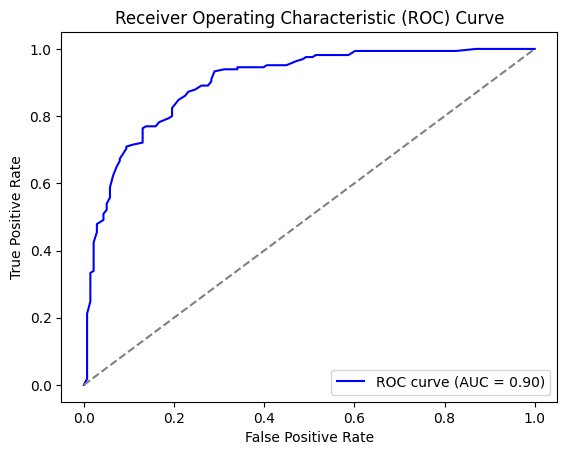

In [ ]:
data = pd.read_csv("Data/heart.csv")
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)

X = data.drop('target', axis=1)
Y = data['target']

avg = k_fold(X,Y,10, 'Random Forest')


Metrics Table Across All Folds for SVM:

              TPR       TNR       FPR  ...       HSS  Brier Score       AUC
Fold                                   ...                                 
1        0.882353  0.785714  0.214286  ...  0.672304     0.135061  0.890756
2        0.937500  0.933333  0.066667  ...  0.870833     0.073532  0.954167
3        0.842105  0.583333  0.416667  ...  0.438914     0.179279  0.776316
4        0.888889  0.750000  0.250000  ...  0.647887     0.137913  0.870370
5        0.923077  0.764706  0.235294  ...  0.669604     0.114490  0.923077
6        0.944444  0.750000  0.250000  ...  0.714286     0.129384  0.888889
7        0.866667  0.600000  0.400000  ...  0.466667     0.155089  0.884444
8        1.000000  0.583333  0.416667  ...  0.626866     0.116121  0.935185
9        0.866667  0.866667  0.133333  ...  0.733333     0.108597  0.928889
10       0.937500  0.785714  0.214286  ...  0.729730     0.088674  0.946429
Average  0.908920  0.740280  0.259720  ...  0.6

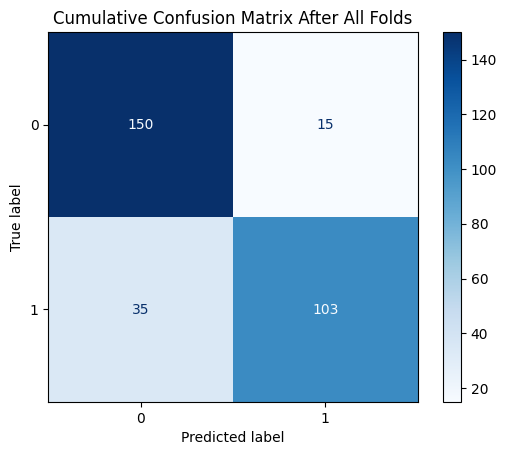

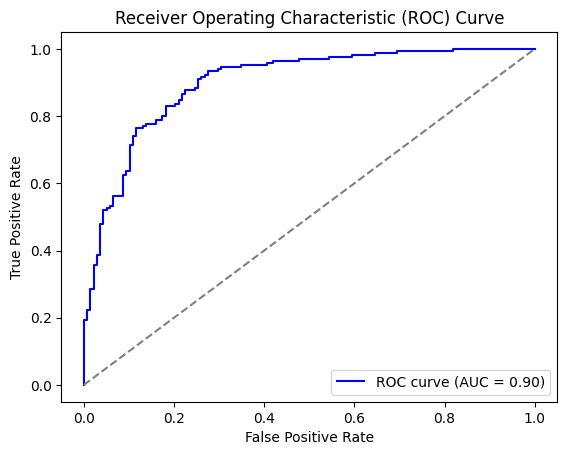

In [45]:
avg = k_fold(X,Y,10, 'SVM')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Metrics Table Across All Folds for LSTM:

              TPR       TNR       FPR  ...       HSS  Brier Score       AUC
Fold                                   ...                                 
1        0.823529  0.785714  0.214286  ...  0.609244     0.152453  0.869748
2        0.937500  0.933333  0.066667  ...  0.870833     0.069794  0.958333
3        0.894737  0.666667  0.333333  ...  0.579186     0.148035  0.837719
4        0.888889  0.833333  0.166667  ...  0.722222     0.124282  0.912037
5        0.923077  0.823529  0.176471  ...  0.733333     0.119730  0.918552
6        0.888889  0.750000  0.250000  ...  0.

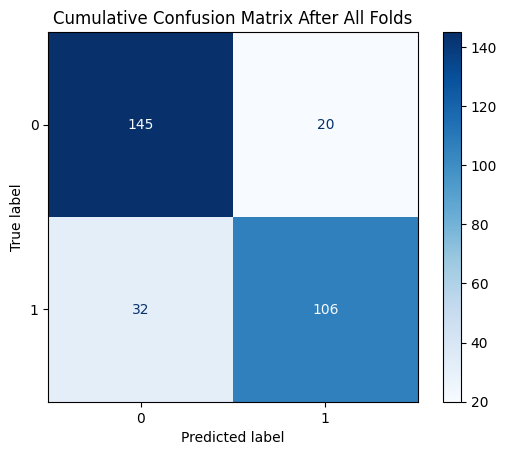

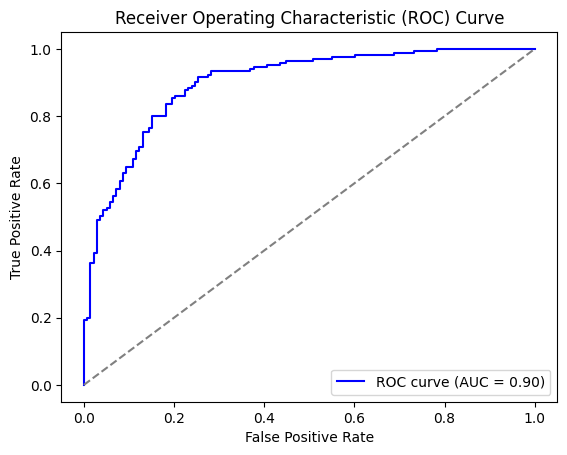

In [46]:
avg = k_fold(X,Y,10, 'LSTM')